In [1]:
from tensorflow.keras.utils import Sequence
import tensorflow as tf
import cv2
import os
import numpy as np
import pandas as pd


path_train = r"D:\DIODE\train\outdoor"

filelist_train = []

for root, dirs, files in os.walk(path_train):
    for file in files:
        filelist_train.append(os.path.join(root, file))

filelist_train.sort()
data_train = {
    "image": [x for x in filelist_train if x.endswith(".png")],
    "depth": [x for x in filelist_train if x.endswith("_depth.npy")],
    "mask": [x for x in filelist_train if x.endswith("_depth_mask.npy")],
}
df_train = pd.DataFrame(data_train)

df_train = df_train.sample(frac=1, random_state=42)



path_val = r"D:\DIODE\val\outdoor"

filelist_val = []

for root, dirs, files in os.walk(path_val):
    for file in files:
        filelist_val.append(os.path.join(root, file))

filelist_val.sort()
data_val = {
    "image": [x for x in filelist_val if x.endswith(".png")],
    "depth": [x for x in filelist_val if x.endswith("_depth.npy")],
    "mask": [x for x in filelist_val if x.endswith("_depth_mask.npy")],
}
df_val = pd.DataFrame(data_val)

df_val = df_val.sample(frac=1, random_state=42)


class DepthDataSequence(Sequence):
    def __init__(self, df, batch_size, crop_size):
        self.df = df
        self.batch_size = batch_size
        self.crop_height, self.crop_width = crop_size

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch = self.df[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        depths = []
        min_depth = 1e-3  # Adjust this value based on your specific requirements
        for _, row in batch.iterrows():
            # Load image, crop it, and normalize it to be in range [0, 1]
            img = cv2.imread(row['image'])
            h, w = img.shape[:2]
            j = (h - self.crop_height) // 2
            i = (w - self.crop_width) // 2
            img = img[j:j + self.crop_height, i:i + self.crop_width] / 255.0

            # Load depth map and take the depth value at the center
            depth = np.load(row['depth'])
            depth = depth[j:j + self.crop_height, i:i + self.crop_width]
            center_depth = depth[depth.shape[0] // 2, depth.shape[1] // 2] / 10.0

            # If center_depth is zero or less than the minimum acceptable depth, skip this image
            if center_depth < min_depth:
                continue

            images.append(img)
            depths.append(center_depth)
            #print(center_depth)

        return np.array(images), np.array(depths)


In [2]:
len(df_train)

16884

In [3]:
crop_size = (200, 600)  # height, width
batch_size = 32
train_gen = DepthDataSequence(df_train[:5600], batch_size, crop_size)
val_gen = DepthDataSequence(df_train[5600:8000], batch_size, crop_size)


In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import efficientnet.tfkeras as efn
from tensorflow.keras import regularizers


# Define input shape based on your data
input_shape = (200, 600, 3)

# Load pre-trained EfficientNet and add custom layers on top
base_model = efn.EfficientNetB5(weights='imagenet', include_top=False, input_shape=input_shape)

# Set layers of base model to non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
predictions = layers.Dense(1)(x)

# Define the new model
model = tf.keras.Model(inputs=base_model.input, outputs=predictions)


In [5]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    amsgrad=False,
)

model.compile(optimizer, loss='mean_squared_error')

history = model.fit(train_gen, validation_data=val_gen, epochs=30)

Epoch 1/30
175/175 [==============================] - 1091s 6s/step - loss: 37.8481 - val_loss: 16.7749
Epoch 2/30
175/175 [==============================] - 769s 4s/step - loss: 9.5579 - val_loss: 5.1703
Epoch 3/30
175/175 [==============================] - 878s 5s/step - loss: 3.6702 - val_loss: 2.9517
Epoch 4/30
175/175 [==============================] - 858s 5s/step - loss: 2.5363 - val_loss: 2.4074
Epoch 5/30
175/175 [==============================] - 1543s 9s/step - loss: 2.0638 - val_loss: 2.2918
Epoch 6/30
175/175 [==============================] - 841s 5s/step - loss: 1.8666 - val_loss: 2.4162
Epoch 7/30
175/175 [==============================] - 856s 5s/step - loss: 1.7322 - val_loss: 2.1717
Epoch 8/30
175/175 [==============================] - 838s 5s/step - loss: 1.6275 - val_loss: 2.1009
Epoch 9/30
175/175 [==============================] - 1222s 7s/step - loss: 1.5633 - val_loss: 2.1068
Epoch 10/30
175/175 [==============================] - 1055s 6s/step - loss: 1.5046 - 

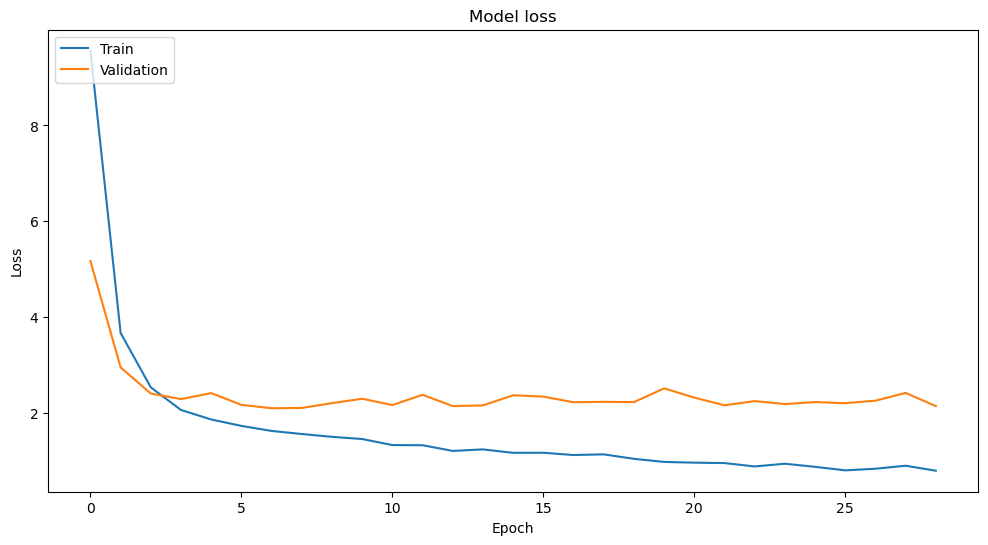

In [6]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
# Freeze all layers in the base model
for layer in model.layers:
    layer.trainable = False

# Unfreeze the last layer
model.layers[-1].trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='mean_squared_error')

history = model.fit(train_gen, validation_data=val_gen, epochs=10)

Epoch 1/10
175/175 [==============================] - 938s 5s/step - loss: 0.7291 - val_loss: 2.1448
Epoch 2/10
175/175 [==============================] - 885s 5s/step - loss: 0.7418 - val_loss: 2.1460
Epoch 3/10
175/175 [==============================] - 1340s 8s/step - loss: 0.7491 - val_loss: 2.1472
Epoch 4/10
175/175 [==============================] - 946s 5s/step - loss: 0.7005 - val_loss: 2.1485
Epoch 5/10
175/175 [==============================] - 917s 5s/step - loss: 0.6969 - val_loss: 2.1498
Epoch 6/10
175/175 [==============================] - 879s 5s/step - loss: 0.6843 - val_loss: 2.1515
Epoch 7/10
175/175 [==============================] - 1260s 7s/step - loss: 0.7345 - val_loss: 2.1531
Epoch 8/10
175/175 [==============================] - 1004s 6s/step - loss: 0.7140 - val_loss: 2.1548
Epoch 9/10
175/175 [==============================] - 1002s 6s/step - loss: 0.7248 - val_loss: 2.1566
Epoch 10/10
175/175 [==============================] - 1034s 6s/step - loss: 0.6906 - v

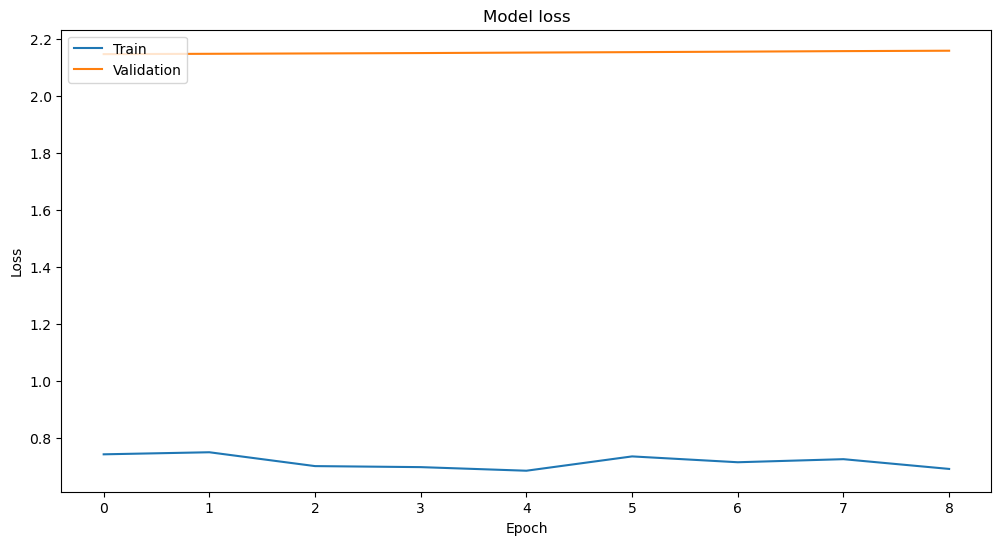

In [8]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predicting the distances on the validation set
val_predictions = model.predict(val_gen)

# Reshaping predictions and true values to one-dimensional arrays
val_predictions = val_predictions.reshape(-1)

# We need to collect the true values from the generator
true_values = []
for _, batch_depths in val_gen:
    true_values.extend(batch_depths)

true_values = np.array(true_values).reshape(-1)

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values, val_predictions)
print(f"Mean Absolute Error (MAE): {mae} meters (normalized)")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values, val_predictions)
print(f"Mean Squared Error (MSE): {mse} meters (normalized)")

75/75 [==============================] - 50s 640ms/step
Mean Absolute Error (MAE): 0.7402794361114502 meters (normalized)
Mean Squared Error (MSE): 2.0216097831726074 meters (normalized)


In [10]:
# De-normalize the predictions and true values
val_predictions_denorm = val_predictions * 10
true_values_denorm = true_values * 10

# Calculate Mean Absolute Error
mae = mean_absolute_error(true_values_denorm, val_predictions_denorm)
print(f"Mean Absolute Error (MAE): {mae} meters")

# Calculate Mean Squared Error
mse = mean_squared_error(true_values_denorm, val_predictions_denorm)
print(f"Mean Squared Error (MSE): {mse} meters")

Mean Absolute Error (MAE): 7.402794361114502 meters
Mean Squared Error (MSE): 202.16099548339844 meters


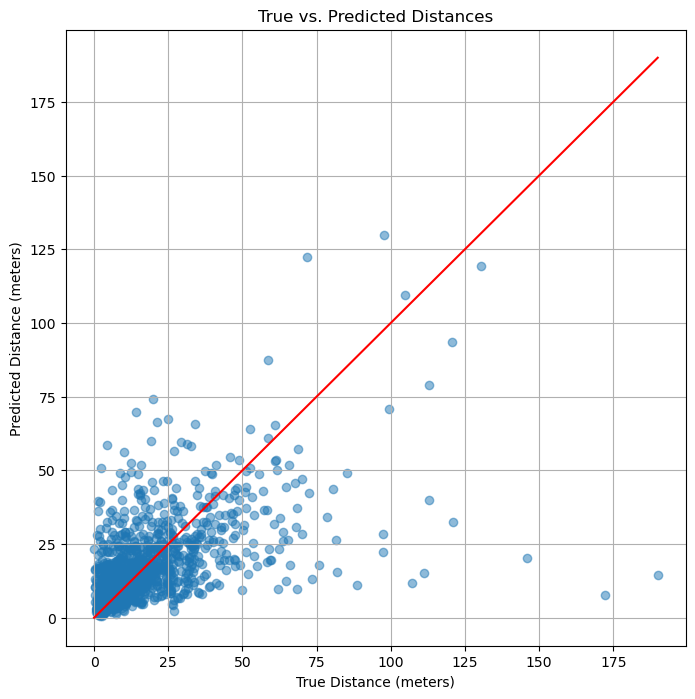

In [11]:
import matplotlib.pyplot as plt

# Scatter plot of true vs. predicted distances
plt.figure(figsize=(8, 8))
plt.scatter(true_values_denorm, val_predictions_denorm, alpha=0.5)
plt.plot([0, max(true_values_denorm)], [0, max(true_values_denorm)], color='red')  # Ideal model would follow this line
plt.xlabel('True Distance (meters)')
plt.ylabel('Predicted Distance (meters)')
plt.title('True vs. Predicted Distances')
plt.grid(True)
plt.show()

In [13]:
model.save('Distance_Prediction_DIODE(outdoor)_EfficicentNet.h5')